<a href="https://colab.research.google.com/github/nishio/missing_value/blob/master/MissingValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

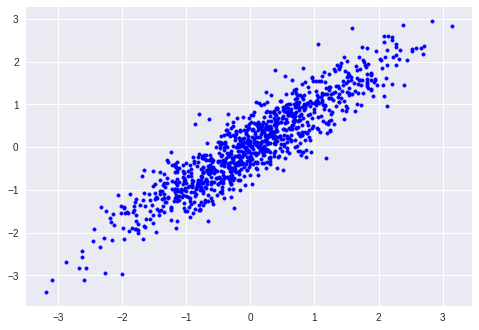

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 1000
hidden = np.random.normal(size=N)
xs = np.random.normal(hidden, 0.3)
ys = np.random.normal(hidden, 0.3)
plt.scatter(xs, ys, color="blue", marker=".")

# Three types of missing values

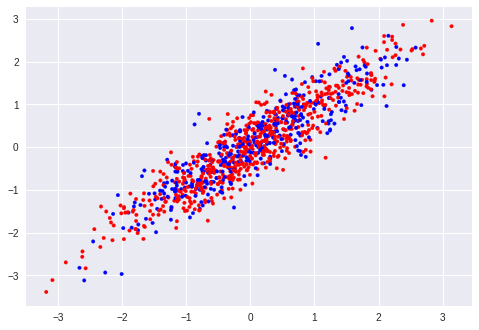

In [0]:
# Missing Completely At Random
random_missing = (np.random.random(N) < 0.6)
plt.scatter(xs, ys, color=["red" if missing else "blue" for missing in random_missing], marker=".")

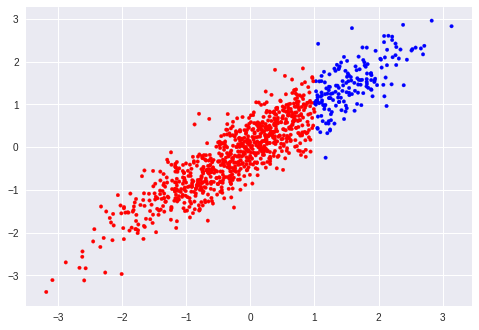

In [0]:
# Missing At Random
plt.scatter(xs, ys, color=["red" if x < 1 else "blue" for x in xs], marker=".")

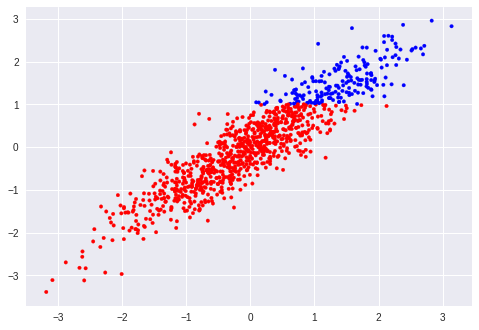

In [0]:
# Missing Not At Random
plt.scatter(xs, ys, color=["red" if y < 1 else "blue" for y in ys], marker=".")

# Utility to draw covariance

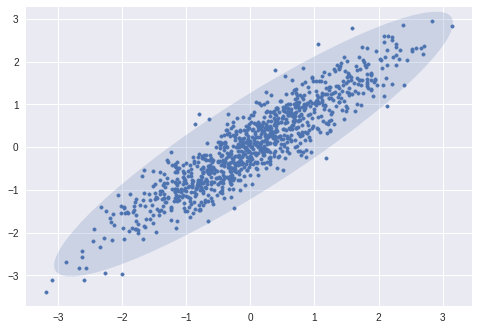

In [0]:
cov = np.cov(xs, ys)
val, vec = np.linalg.eigh(cov)
trans = np.diag(np.sqrt(val)).dot(vec)
transform = matplotlib.transforms.Affine2D.from_values(*trans.flatten(), e=xs.mean(), f=ys.mean())

plt.scatter(xs, ys, marker=".")
ax = plt.gca().add_collection(
 matplotlib.collections.PatchCollection([matplotlib.patches.Circle((0, 0), radius=3, transform=transform)], alpha=0.2))

In [0]:
def draw_cov(xs, ys):
    cov = np.cov(xs, ys)
    val, vec = np.linalg.eigh(cov)
    trans = np.diag(np.sqrt(val)).dot(vec)
    transform = matplotlib.transforms.Affine2D.from_values(*trans.flatten(), e=xs.mean(), f=ys.mean())
    ax = plt.gca().add_collection(
    matplotlib.collections.PatchCollection([matplotlib.patches.Circle((0, 0), radius=3, transform=transform)], alpha=0.2))

# Omit missing values

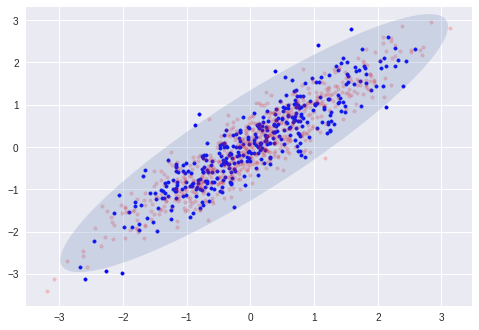

In [0]:
# Missing Completely At Random
plt.scatter(xs[~random_missing], ys[~random_missing], color="blue", marker=".")
plt.scatter(xs[random_missing], ys[random_missing], color="red", marker=".", alpha=0.2)

draw_cov(xs[~random_missing], ys[~random_missing])

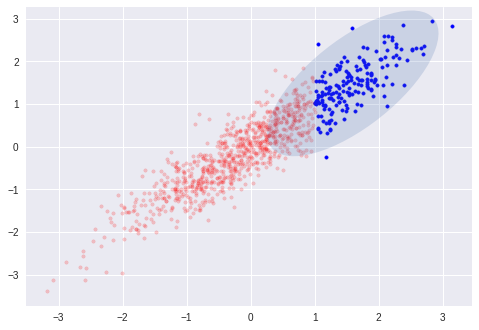

In [0]:
# Missing At Random
missing = (xs < 1)

plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)

draw_cov(xs[~missing], ys[~missing])

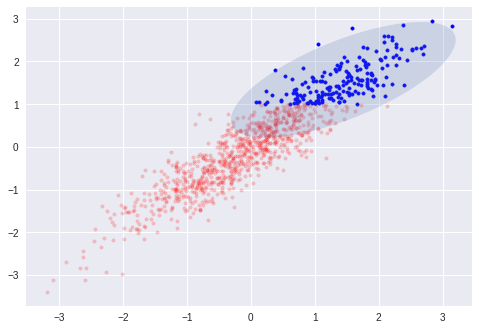

In [0]:
# Missing Not At Random
missing = (ys < 1)

plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)

draw_cov(xs[~missing], ys[~missing])

# Fill missing values with mean

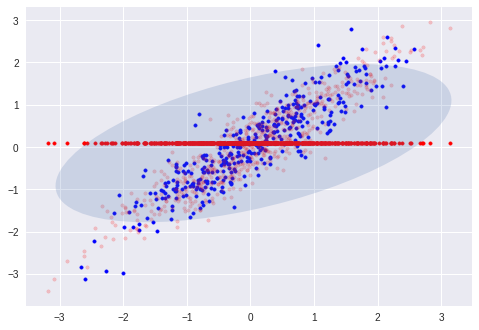

In [0]:
# Missing Completely At Random
hat_ys = ys.copy()
hat_ys[random_missing] = ys[~random_missing].mean()
plt.scatter(xs[~random_missing], ys[~random_missing], color="blue", marker=".")
plt.scatter(xs[random_missing], ys[random_missing], color="red", marker=".", alpha=0.2)
plt.scatter(xs[random_missing], hat_ys[random_missing], color="red", marker=".")

draw_cov(xs, hat_ys)

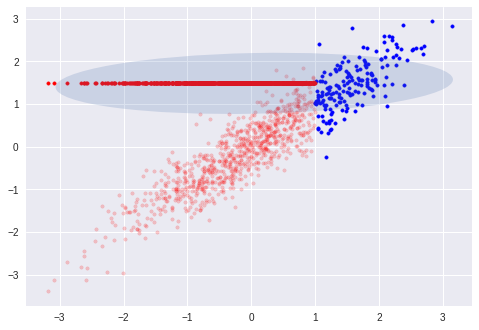

In [0]:
# Missing At Random
missing = (xs < 1)

hat_ys = ys.copy()
hat_ys[missing] = ys[~missing].mean()
plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)
plt.scatter(xs[missing], hat_ys[missing], color="red", marker=".")
draw_cov(xs, hat_ys)

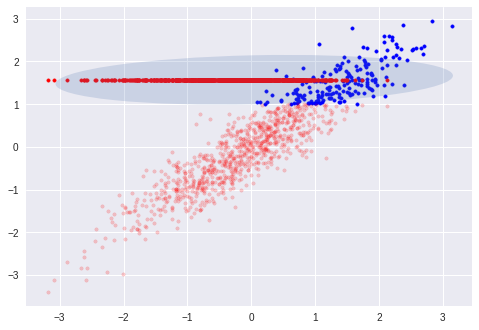

In [0]:
# Missing Not At Random
missing = (ys < 1)

hat_ys = ys.copy()
hat_ys[missing] = ys[~missing].mean()
plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)
plt.scatter(xs[missing], hat_ys[missing], color="red", marker=".")
draw_cov(xs, hat_ys)

# Linear Regression

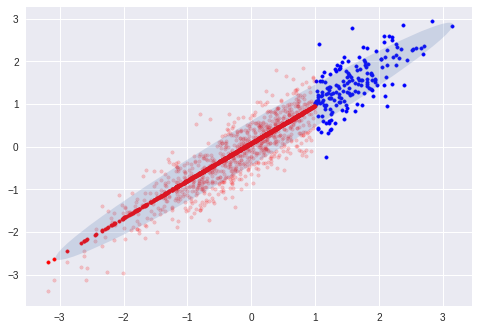

In [0]:
# Missing At Random
missing = (xs < 1)

from sklearn.linear_model import LinearRegression
hat_ys = ys.copy()
m = LinearRegression().fit(xs[~missing].reshape(-1, 1), ys[~missing].reshape(-1, 1))

hat_ys[missing] = m.predict(xs[missing].reshape(-1, 1)).reshape(-1)
plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)
plt.scatter(xs[missing], hat_ys[missing], color="red", marker=".")
draw_cov(xs, hat_ys)

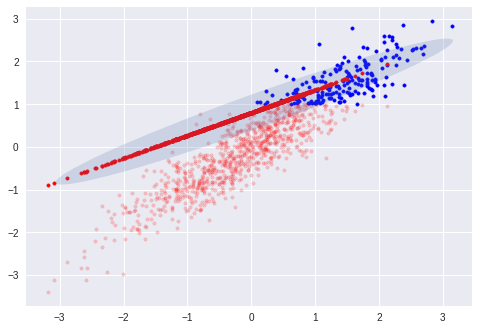

In [0]:
# Missing Not At Random
missing = (ys < 1)

from sklearn.linear_model import LinearRegression
hat_ys = ys.copy()
m = LinearRegression().fit(xs[~missing].reshape(-1, 1), ys[~missing].reshape(-1, 1))

hat_ys[missing] = m.predict(xs[missing].reshape(-1, 1)).reshape(-1)
plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)
plt.scatter(xs[missing], hat_ys[missing], color="red", marker=".")
draw_cov(xs, hat_ys)

# Counterfactual Approach

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 468.205160
         Iterations: 11
         Function evaluations: 753


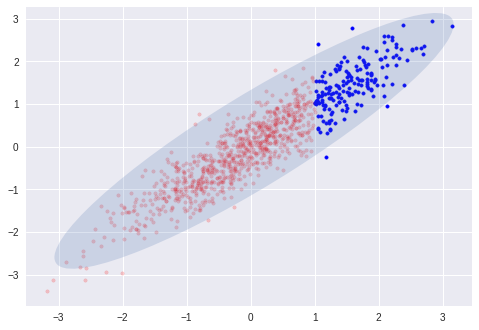

In [0]:
# negative log likelihood of 2d gauss
def nll2dg(args):
    (mu1, mu2, sig11, sig12, sig22) = args
    N = len(xs[~missing])
    Sigma = np.array([[sig11, sig12], [sig12, sig22]])
    det = np.linalg.det(Sigma)
    if det <= 0.0: return np.inf
    invSigma = np.linalg.inv(Sigma)
    mu = np.array([mu1, mu2])
    ret = np.log(det) * N / 2
    for xy in zip(xs[~missing], ys[~missing]):
        diff = xy - mu
        ret += np.dot(np.dot(diff.transpose(), invSigma), diff) / 2

    if np.isnan(ret): return np.inf
    return ret
  
# negative log likelihood of 1d gauss
def nll1dg(args):
  (mu1, mu2, sig11, sig12, sig22) = args
  data = xs[missing]
  if sig11 < 0.0: return np.inf
  ret = np.log(sig11) * data.shape[0] / 2
  for x in data:
      diff = x - mu1
      ret += diff ** 2 / (2 * sig11)
      
  if np.isnan(ret): return np.inf
  return ret

# negative log likelihood
def nll(args):
  ret = nll2dg(args) + nll1dg(args)
  if np.isnan(ret): return np.inf
  return ret

missing = (xs < 1)

import scipy
init_param = (0, 0, 1, 0, 1)
(mu1, mu2, sig11, sig12, sig22) = scipy.optimize.fmin_powell(nll, init_param)

plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)

cov = np.array([[sig11, sig12], [sig12, sig22]])
val, vec = np.linalg.eigh(cov)
trans = np.diag(np.sqrt(val)).dot(vec)
transform = matplotlib.transforms.Affine2D.from_values(*trans.flatten(), e=mu1, f=mu2)
ax = plt.gca().add_collection(
matplotlib.collections.PatchCollection([matplotlib.patches.Circle((0, 0), radius=3, transform=transform)], alpha=0.2))

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 420.900626
         Iterations: 9
         Function evaluations: 619


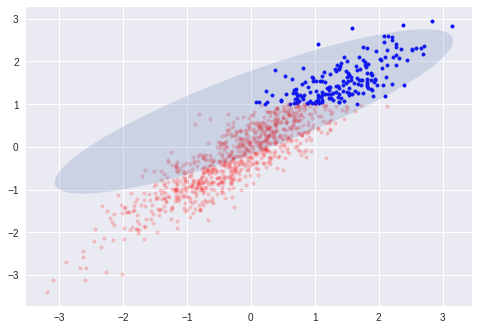

In [0]:
missing = (ys < 1)

init_param = (0, 0, 1, 0, 1)
(mu1, mu2, sig11, sig12, sig22) = scipy.optimize.fmin_powell(nll, init_param)

plt.scatter(xs[~missing], ys[~missing], color="blue", marker=".")
plt.scatter(xs[missing], ys[missing], color="red", marker=".", alpha=0.2)

cov = np.array([[sig11, sig12], [sig12, sig22]])
val, vec = np.linalg.eigh(cov)
trans = np.diag(np.sqrt(val)).dot(vec)
transform = matplotlib.transforms.Affine2D.from_values(*trans.flatten(), e=mu1, f=mu2)
ax = plt.gca().add_collection(
matplotlib.collections.PatchCollection([matplotlib.patches.Circle((0, 0), radius=3, transform=transform)], alpha=0.2))